# 예제 3.5번(경험에의한 Value Update)

<img src="img/행동문제상황.png" style="width: 500px;" align="left"/>


왼쪽과 같은 문제상황.    
5X5 Grid안에서    
Action은 상,하,좌,우가 가능함 
       
이번에는 State Value가 아니라 5X5 Action Value Table을 만들어내는 것을 목표로 접근.   
** Continouing Task가 아니라, Episodic Task로 문제를 풀이함.    

Reference : https://github.com/michaeltinsley/Gridworld-with-Q-Learning-Reinforcement-Learning-

### Action Value Table vs State Value Table
- Action Value 방식은 Action Value에 대한Table과, Reward 파악을 위한 각 State별 Reward Table 두가지를 별도로 만들어줘야함.     
- 반면 State Value는 하나만 있으면 됨-> State Table에 그대로 Reward를 기입해주면 되기 때문

In [6]:
import numpy as np
import operator
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
# 환경에 대한 정의

class GridWorld:
    def __init__(self):
        # Grid World 정보 설정
        self.height = 5
        self.width = 5
        self.grid = np.zeros(( self.height, self.width)) - 1
        
        
        # 시작위치는 맨 아래 0~4 Grid 사이
        self.current_location = (4,np.random.randint(0,5))
        
        
        # Reward 지점은 맨 오른쪽 1,4와 3,4 
        self.gold_1_location = (0,1)
        self.gold_2_location = (0,3)
        self.terminal_states = [ self.gold_1_location, self.gold_2_location]
        
        
        # 각각 100점과 50점
        self.grid[ self.gold_1_location[0], self.gold_1_location[1]] = 100
        self.grid[ self.gold_2_location[0], self.gold_2_location[1]] = 50
        
        # 가능한 행동은 4개
        self.actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
    
        
    ## Put methods here:
    def get_available_actions(self):
        """Returns possible actions"""
        return self.actions
    
    def agent_on_map(self):
        """Prints out current location of the agent on the grid (used for debugging)"""
        grid = np.zeros(( self.height, self.width))
        grid[ self.current_location[0], self.current_location[1]] = 1
        return grid
    
    def get_reward(self, new_location):
        """Returns the reward for an input position"""
        return self.grid[ new_location[0], new_location[1]]
    
    def make_step(self, action):
        """Moves the agent in the specified direction. If agent is at a border, agent stays still
        but takes negative reward. Function returns the reward for the move."""
        # Store previous location
        last_location = self.current_location
        
        # 벽에 닿으면 -30점 되도록 추가해봄
        # location은 알아서 갱신되도록 짜여있음.
        # UP
        if action == 'UP':
            if last_location[0] == 0:
                reward = self.get_reward(last_location)-30
            else:
                self.current_location = ( self.current_location[0] - 1, self.current_location[1])
                reward = self.get_reward(self.current_location)
        
        # DOWN
        elif action == 'DOWN':
            if last_location[0] == self.height - 1:
                reward = self.get_reward(last_location)-30
            else:
                self.current_location = ( self.current_location[0] + 1, self.current_location[1])
                reward = self.get_reward(self.current_location)
            
        # LEFT
        elif action == 'LEFT':
            if last_location[1] == 0:
                reward = self.get_reward(last_location)-30
            else:
                self.current_location = ( self.current_location[0], self.current_location[1] - 1)
                reward = self.get_reward(self.current_location)

        # RIGHT
        elif action == 'RIGHT':
            if last_location[1] == self.width - 1:
                reward = self.get_reward(last_location)-30
            else:
                self.current_location = ( self.current_location[0], self.current_location[1] + 1)
                reward = self.get_reward(self.current_location)
                
        return reward
    
    def check_state(self):
        """Check if the agent is in a terminal state (gold or bomb), if so return 'TERMINAL'"""
        if self.current_location in self.terminal_states:
            return 'TERMINAL'

In [8]:
# Reference 참고삼아 Learn하는 부분만 이번 챕터 알고리즘으로 바꾼 Agent



class ActionValue_Agent():
    # Intialize
    def __init__(self, environment, epsilon=0.03, gamma=0.9):
        self.environment = environment
        self.q_table = dict() # Store all Q-values in dictionary of dictionaries 
        for x in range(environment.height): # Loop through all possible grid spaces, create sub-dictionary for each
            for y in range(environment.width):
                self.q_table[(x,y)] = {'UP':0, 'DOWN':0, 'LEFT':0, 'RIGHT':0} # Populate sub-dictionary with zero values for possible moves

        self.epsilon = epsilon
        self.gamma = gamma
    
    
    def choose_action(self, available_actions):
        """Returns the optimal action from Value table. If multiple optimal actions, chooses random choice.
        Will make an exploratory random action dependent on epsilon."""
        
        
        
        # 행동 선택시, Eplison만큼 Explore
        if np.random.uniform(0,1) < self.epsilon:
            action = available_actions[np.random.randint(0, len(available_actions))]
        else:
            q_values_of_state = self.q_table[self.environment.current_location]
            maxValue = max(q_values_of_state.values()) # One-step Ahead Search 과정 없이 선택가능
            action = np.random.choice([k for k, v in q_values_of_state.items() if v == maxValue])
        return action
    
    
    
    
    def learn(self, old_state, reward, new_state, action):
        """Updates the Q-value table using Q-learning"""
        q_values_of_state = self.q_table[new_state]
        max_q_value_in_new_state = max(q_values_of_state.values()) 
        current_q_value = self.q_table[old_state][action]
        
        
        # 수정한 부분
        # 놓여있던 state ( (0,0)~(4,4) )의 Action Value값 수정
        # 여기서 State, Action이 정해지면, 어떤 Reward, 다음State 가 주어지는지가 100%의 확률이라 바로 적용
        # 만약 여러가지 경우의 수가 생긴다면 모든 경우의 수를 합쳐주면 됨.
        self.q_table[old_state][action] = reward + self.gamma*max_q_value_in_new_state

In [34]:
#  이건 뒷부분 알고리즘인 Q-Agent인데, 그냥 일단은 적용만.
class Q_Agent():
    # Intialize
    def __init__(self, environment, epsilon=0.03, alpha=0.1, gamma=1):
        self.environment = environment
        self.q_table = dict() # Store all Q-values in dictionary of dictionaries 
        for x in range(environment.height): # Loop through all possible grid spaces, create sub-dictionary for each
            for y in range(environment.width):
                self.q_table[(x,y)] = {'UP':0, 'DOWN':0, 'LEFT':0, 'RIGHT':0} # Populate sub-dictionary with zero values for possible moves

        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        
    def choose_action(self, available_actions):
        """Returns the optimal action from Q-Value table. If multiple optimal actions, chooses random choice.
        Will make an exploratory random action dependent on epsilon."""
        if np.random.uniform(0,1) < self.epsilon:
            action = available_actions[np.random.randint(0, len(available_actions))]
        else:
            q_values_of_state = self.q_table[self.environment.current_location]
            maxValue = max(q_values_of_state.values())
            action = np.random.choice([k for k, v in q_values_of_state.items() if v == maxValue])
        
        return action
    
    def learn(self, old_state, reward, new_state, action):
        """Updates the Q-value table using Q-learning"""
        q_values_of_state = self.q_table[new_state]
        max_q_value_in_new_state = max(q_values_of_state.values())
        current_q_value = self.q_table[old_state][action]
        
        
        
        # Q-Value 알고리즘은 아래와 같음. (과거랑 현재에 대한 지수 이동평균 공식같음. 뒤에 가봐야 제대로 알 수 있을듯함)
        self.q_table[old_state][action] = (1 - self.alpha) * current_q_value + self.alpha * (reward + self.gamma * max_q_value_in_new_state)

        

In [35]:
def play(environment, agent, trials=500, max_steps_per_episode=3000, learn=False):
    """The play function runs iterations and updates Q-values if desired."""
    reward_per_episode = [] # Initialise performance log
    
    for trial in range(trials): # Run trials
        cumulative_reward = 0 # Initialize values of each game
        step = 0
        game_over = False
        while step < max_steps_per_episode and game_over != True: # Run until max steps or until game is finished
            old_state = environment.current_location
            action = agent.choose_action(environment.actions) 
            reward = environment.make_step(action)
            new_state = environment.current_location
            
            if learn == True: # Update Q-values if learning is specified
                agent.learn(old_state, reward, new_state, action)
                
            cumulative_reward += reward
            step += 1
            
            if environment.check_state() == 'TERMINAL': # If game is in terminal state, game over and start next trial
                environment.__init__()
                game_over = True     
                
        reward_per_episode.append(cumulative_reward) # Append reward for current trial to performance log
        
    return reward_per_episode # Return performance log

학습이 되기도 하고, 가끔 안되기도 하는데.. 일단은.. 그냥넘어감

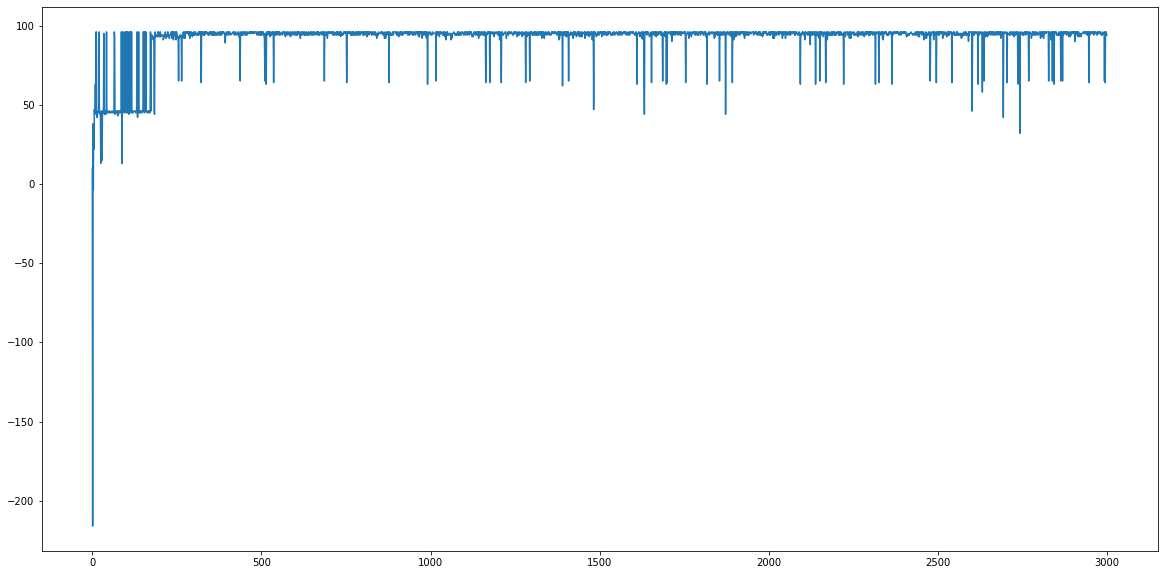

In [56]:
environment = GridWorld()
agentAction = ActionValue_Agent(environment)

# Note the learn=True argument!
reward_per_episode_Action = play(environment, agentAction, trials=3000, learn=True)

# Simple learning curve
plt.figure(figsize=(20,10))
plt.plot(reward_per_episode_Action)

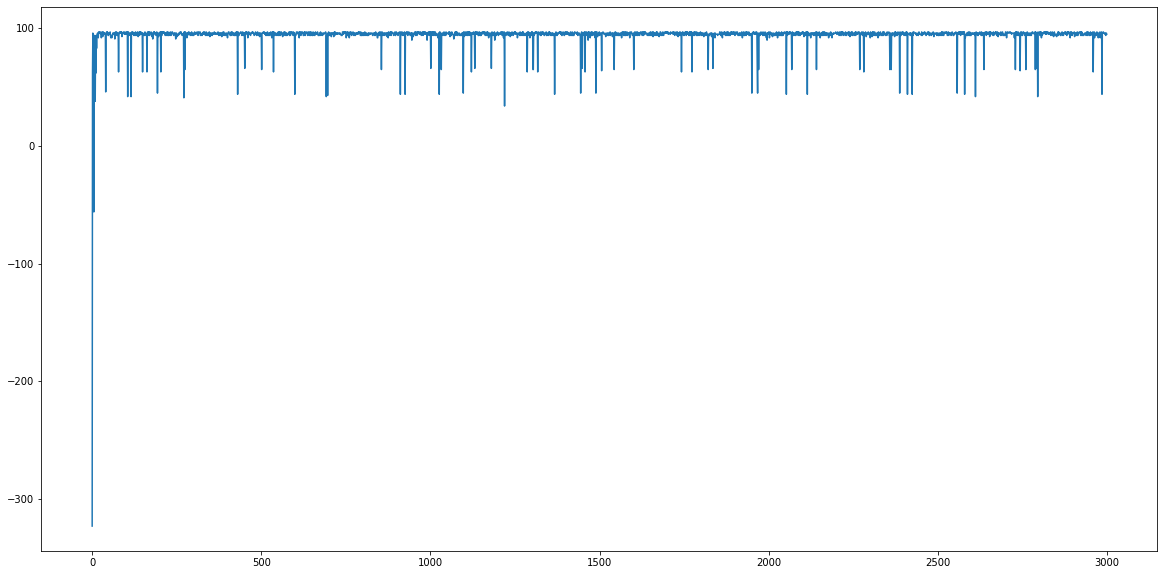

In [57]:
environment = GridWorld()
agentQ = Q_Agent(environment)

# Note the learn=True argument!
reward_per_episode = play(environment, agentQ, trials=3000, learn=True)

# Simple learning curve
plt.figure(figsize=(20,10))
plt.plot(reward_per_episode)

In [58]:
def pretty(d, indent=0):
    for key, value in d.items():
        print('\t' * indent + str(key))
        if isinstance(value, dict):
            pretty(value, indent+1)
        else:
            print('\t' * (indent+1) + str(value))



In [59]:
# pretty(agentAction.q_table)

In [60]:
# pretty(agentQ.q_table)

# 결과 Visualization

### ActionValue_Agent 결과

0 0 {'UP': 59.0, 'DOWN': 79.10000000000001, 'LEFT': 0, 'RIGHT': 100.0}
0 1 {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}
0 2 {'UP': 59.0, 'DOWN': 79.10000000000001, 'LEFT': 100.0, 'RIGHT': 50.0}
0 3 {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}
0 4 {'UP': 0, 'DOWN': -1.0, 'LEFT': 0, 'RIGHT': -31.0}
1 0 {'UP': 89.0, 'DOWN': 70.19000000000001, 'LEFT': 49.10000000000001, 'RIGHT': 89.0}
1 1 {'UP': 100.0, 'DOWN': 79.10000000000001, 'LEFT': 79.10000000000001, 'RIGHT': 79.10000000000001}
1 2 {'UP': 89.0, 'DOWN': 70.19000000000001, 'LEFT': 89.0, 'RIGHT': 70.19000000000001}
1 3 {'UP': 50.0, 'DOWN': 62.171000000000014, 'LEFT': 79.10000000000001, 'RIGHT': 62.171000000000014}
1 4 {'UP': -1.0, 'DOWN': 33.74, 'LEFT': 70.19000000000001, 'RIGHT': -31.0}
2 0 {'UP': 79.10000000000001, 'DOWN': 62.171000000000014, 'LEFT': 40.19000000000001, 'RIGHT': 79.10000000000001}
2 1 {'UP': 89.0, 'DOWN': 54.95390000000001, 'LEFT': 70.19000000000001, 'RIGHT': 70.19000000000001}
2 2 {'UP': 79.10000000000001, 'DOWN': 62.171

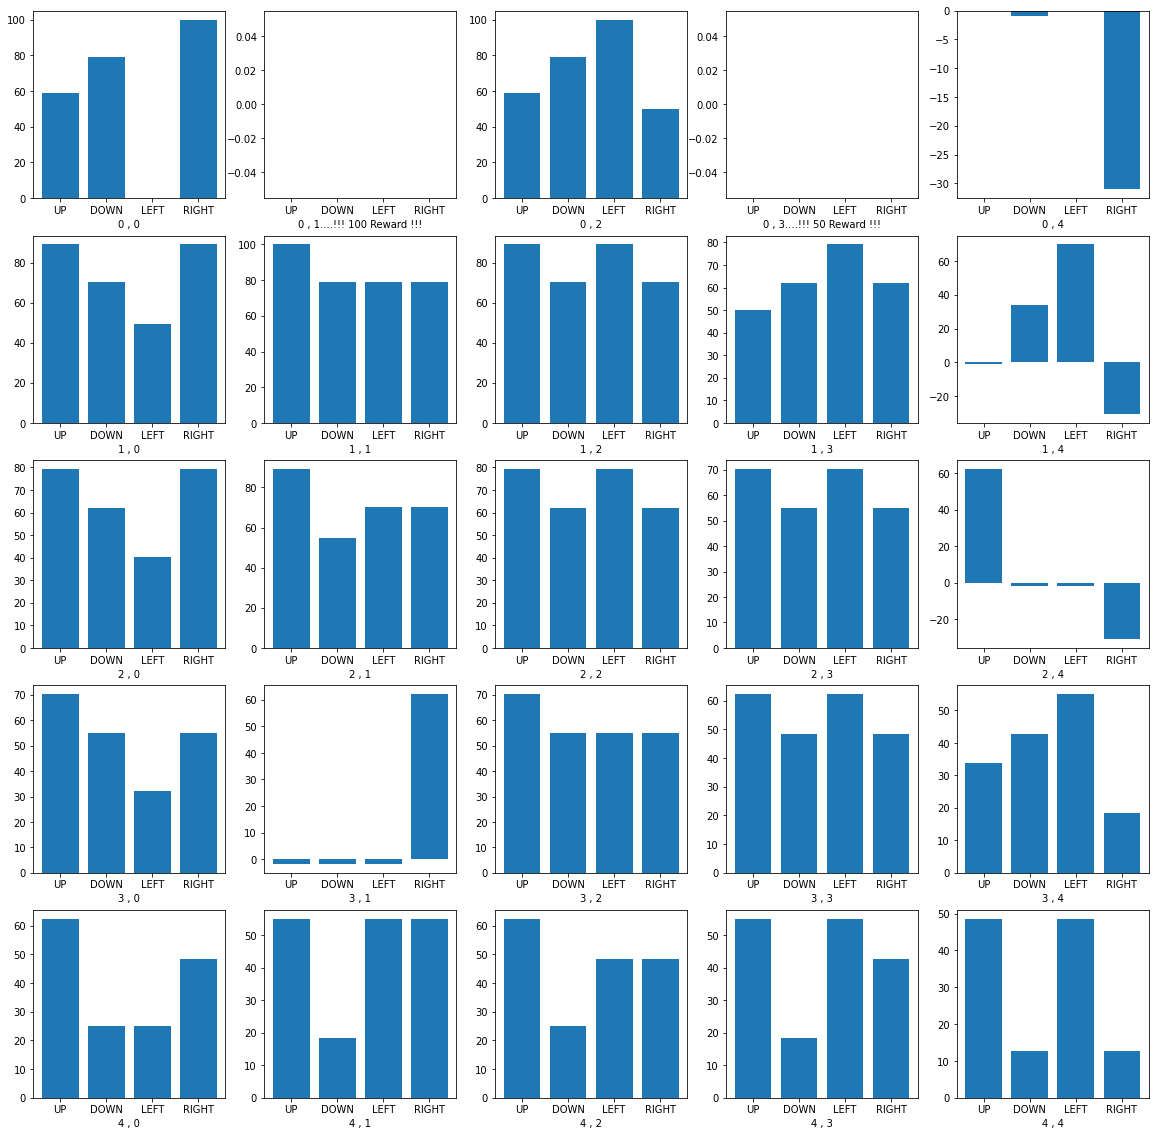

In [61]:
plt.figure(figsize=(20,20))
for position,q_value in agentAction.q_table.items():
    index = 5*position[0]+position[1]
    plt.subplot(5,5,index+1)
    
    keys = []
    values = []
    for key,value in q_value.items():
        keys.append(key)
        values.append(value)
    print(position[0],position[1],q_value)
    plt.bar(keys,values)
    
    if position[0]==0 and position[1]==1:
        plt.xlabel(str(position[0])+ ' , '+str(position[1])+'....!!! 100 Reward !!!',fontsize=10) 
    elif position[0]==0 and position[1]==3:
        plt.xlabel(str(position[0])+ ' , '+str(position[1])+'....!!! 50 Reward !!!',fontsize=10) 
    else:
        plt.xlabel(str(position[0])+ ' , '+str(position[1]),fontsize=10)

### Q_Agent 결과

0 0 {'UP': 0, 'DOWN': -0.1, 'LEFT': -3.1, 'RIGHT': 0}
0 1 {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}
0 2 {'UP': -3.1, 'DOWN': -0.1, 'LEFT': 10.0, 'RIGHT': 0}
0 3 {'UP': 0, 'DOWN': 0, 'LEFT': 0, 'RIGHT': 0}
0 4 {'UP': -3.1, 'DOWN': -0.1, 'LEFT': 0, 'RIGHT': -3.1}
1 0 {'UP': -0.1, 'DOWN': -0.11000000000000001, 'LEFT': -3.1, 'RIGHT': 78.594975347474}
1 1 {'UP': 99.99999999999996, 'DOWN': 84.74814409475663, 'LEFT': 42.05347662171959, 'RIGHT': 28.87695502216293}
1 2 {'UP': -0.19, 'DOWN': -0.1, 'LEFT': 9.809999999999997, 'RIGHT': 40.42785651969686}
1 3 {'UP': 48.092397877615284, 'DOWN': 0, 'LEFT': -0.1, 'RIGHT': -0.1}
1 4 {'UP': -0.1, 'DOWN': -0.1, 'LEFT': 2.2711, 'RIGHT': -3.1}
2 0 {'UP': 4.969795826835227, 'DOWN': 7.521797242510931, 'LEFT': -3.1, 'RIGHT': 84.73381021813283}
2 1 {'UP': 98.99999999999987, 'DOWN': 87.00481118385001, 'LEFT': 57.88129612826701, 'RIGHT': 68.36381993513297}
2 2 {'UP': 2.575423688008727, 'DOWN': -0.1, 'LEFT': 96.77251773903976, 'RIGHT': -0.1}
2 3 {'UP': -0.19, 'D

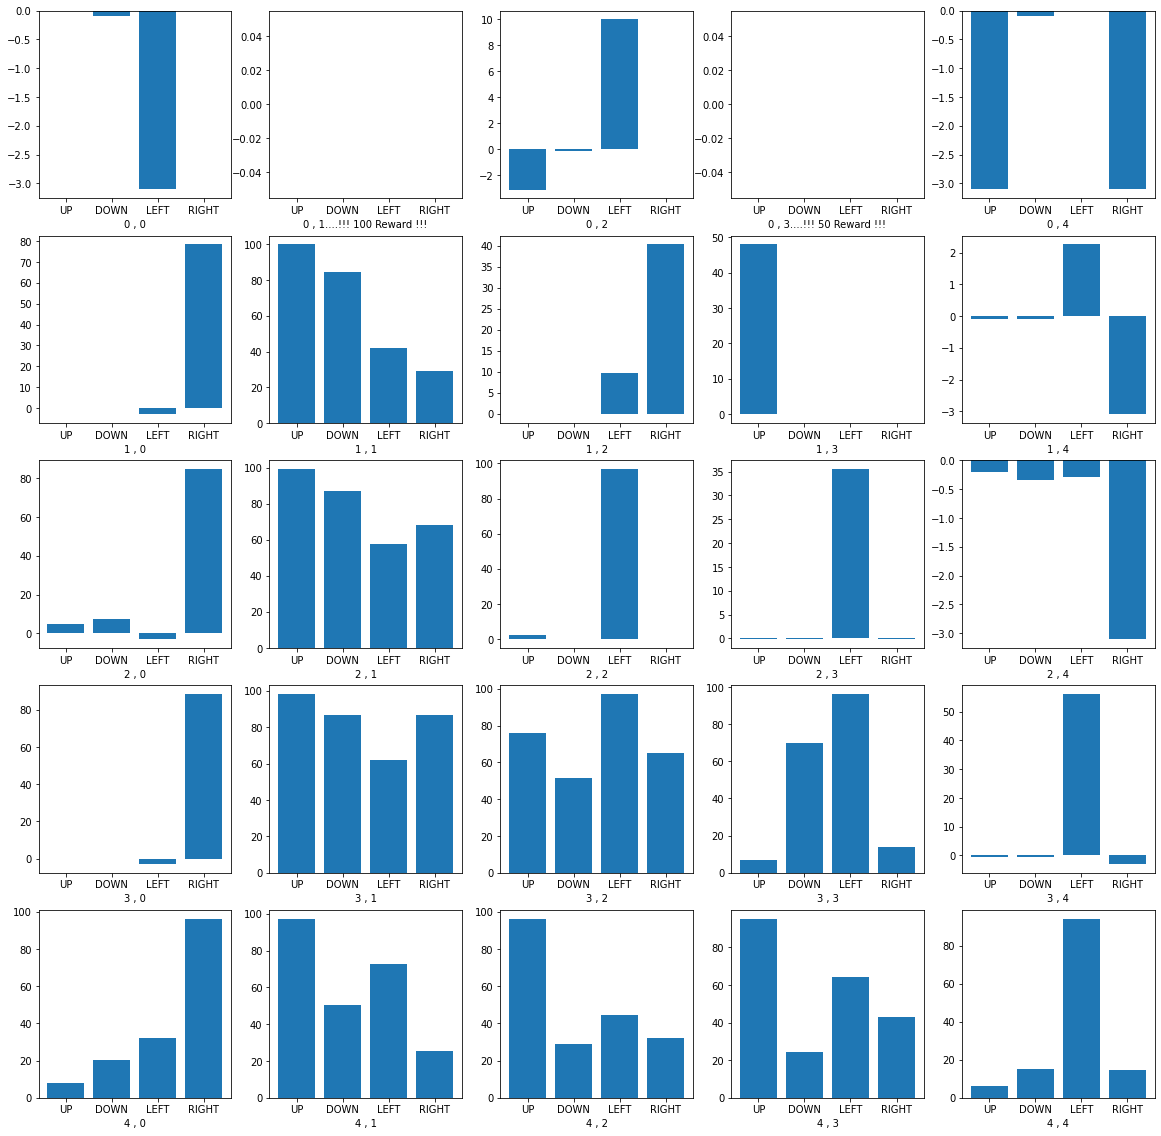

In [62]:
plt.figure(figsize=(20,20))
for position,q_value in agentQ.q_table.items():
    index = 5*position[0]+position[1]
    plt.subplot(5,5,index+1)
    
    keys = []
    values = []
    for key,value in q_value.items():
        keys.append(key)
        values.append(value)
    print(position[0],position[1],q_value)
    plt.bar(keys,values)
    
    if position[0]==0 and position[1]==1:
        plt.xlabel(str(position[0])+ ' , '+str(position[1])+'....!!! 100 Reward !!!',fontsize=10) 
    elif position[0]==0 and position[1]==3:
        plt.xlabel(str(position[0])+ ' , '+str(position[1])+'....!!! 50 Reward !!!',fontsize=10)  
    else:
        plt.xlabel(str(position[0])+ ' , '+str(position[1]),fontsize=10)